Weather Forecasting with 4 features using historical data via TDNN

In [ ]:
# Required Import Statements
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math


In [ ]:
# Convert time series data to supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n_out)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
# Function to Create Sequences
def create_sequences(data, window_size=10):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size]) # 1..10, 2..11, 3..12, ......
        labels.append(data[i+window_size])
    return np.array(sequences), np.array(labels)

In [ ]:
# Define the TDNN Model
class TDNN(nn.Module):
    def __init__(self, window_size1=10):
        super(TDNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.fc = nn.Linear(32 * window_size1, 4)  # Adjust based on the output of conv layers

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
# Evaluation Function
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
    predictions = predictions.numpy()
    y_test = y_test.numpy()

    mae = mean_absolute_error(y_test, predictions)
    rmse = math.sqrt(mean_squared_error(y_test, predictions))
    return mae, rmse

In [ ]:
# Link to 6 weather datasets
url_ottawa = "https://raw.githubusercontent.com/noobstang/NNtraining/master/Weather49Sets/weatherstats_ottawa_daily.csv"
url_ottawa_south = "https://raw.githubusercontent.com/noobstang/NNtraining/master/Weather49Sets/weatherstats_ottawasouth_daily.csv"
url_gatineau = "https://raw.githubusercontent.com/noobstang/NNtraining/master/Weather49Sets/weatherstats_gatineau_daily.csv"
url_chelsea = "https://raw.githubusercontent.com/noobstang/NNtraining/master/Weather49Sets/weatherstats_chelsea_daily.csv"
url_kemptville = "https://raw.githubusercontent.com/noobstang/NNtraining/master/Weather49Sets/weatherstats_kemptville_daily.csv"
url_renfrew = "https://raw.githubusercontent.com/noobstang/NNtraining/master/Weather49Sets/weatherstats_renfrew_daily.csv"

# Load and Preprocess Data
url = url_ottawa_south
#url = 'https://raw.githubusercontent.com/Sattar-A/HonoursProject_CSI4900/main/data/weatherstats_ottawa_daily.csv?token=GHSAT0AAAAAACNBWJ7MI3IZIOPLGQ6OLTU4ZPPCOYA'
data = pd.read_csv(url)

# data processing transformation
data['date'] = pd.to_datetime(data['date'])
filtered_data = data[(data['date'].dt.month >= 5) & (data['date'].dt.month <= 11)]  # restrict data range from May to November
filtered_data = filtered_data[(filtered_data['date'].dt.year >= 2013) & (filtered_data['date'].dt.year <= 2023)]  # overall data range from years 2013-2023
selected_columns = ['avg_hourly_temperature', 'precipitation', 'solar_radiation', 'avg_hourly_pressure_station']  # set 4 features for input and output
final_data = filtered_data[selected_columns]
# test data processing
test_data = final_data[(filtered_data['date'].dt.year == 2023)] # data from 2023 only
test_data = final_data[(filtered_data['date'].dt.year <= 2022)]

#window size
window_size = 14
pred_size = 1

# Handle Missing Values
#final_data = final_data.fillna(method='ffill')  # option 1: forward fill
final_data = final_data.dropna()  # option 2: drop data with null values

# Normalize the Data
scaler = MinMaxScaler()  # MinMax scaler
scaled_data = scaler.fit_transform(final_data)

<ipython-input-72-2ef2e57b3caf>:12: DtypeWarning: Columns (46,49) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(url)


In [ ]:
# Assuming `scaled_data` is your normalized dataset
prepared_data = series_to_supervised(scaled_data, n_in=window_size, n_out=pred_size)

# Split into input and output parts
X = prepared_data.iloc[:, :-(4*1)].values  # 4 features, last columns are the output
y = prepared_data.iloc[:, -4:].values  # last 4 columns as the output

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)


In [ ]:
print(X)

tensor([[0.3932, 0.0000, 0.1376,  ..., 0.0304, 0.0205, 0.4046],
        [0.2540, 0.0025, 0.1427,  ..., 0.0000, 0.2810, 0.6281],
        [0.2106, 0.0000, 0.1894,  ..., 0.0000, 0.1603, 0.6667],
        ...,
        [0.7959, 0.0000, 0.7842,  ..., 0.0127, 0.4310, 0.4663],
        [0.7646, 0.0076, 0.7939,  ..., 0.0000, 0.6123, 0.5164],
        [0.7699, 0.0127, 0.7665,  ..., 0.0000, 0.8279, 0.5414]])


In [ ]:
# Function to Create Sequences for model training
X, y = create_sequences(scaled_data, window_size)

# Splitting the Data and reshaping to 'parallelogram stack'
dates = filtered_data['date'].values
index_2023 = np.where(dates >= np.datetime64('2023-01-01'))[0][0] - window_size

X_train, X_test = X[:index_2023], X[index_2023:]
y_train, y_test = y[:index_2023], y[index_2023:]




In [ ]:
print(X_train)

[[[0.39318024 0.         0.13759708 0.44123314]
  [0.25400139 0.00253165 0.14273338 0.47206166]
  [0.21062399 0.         0.18939324 0.39884393]
  ...
  [0.328926   0.         0.18116278 0.49325626]
  [0.34585943 0.         0.28175377 0.46820809]
  [0.50753885 0.03037975 0.02051425 0.40462428]]

 [[0.25400139 0.00253165 0.14273338 0.47206166]
  [0.21062399 0.         0.18939324 0.39884393]
  [0.37485502 0.         0.11754695 0.29094412]
  ...
  [0.34585943 0.         0.28175377 0.46820809]
  [0.50753885 0.03037975 0.02051425 0.40462428]
  [0.4453723  0.         0.28101117 0.62813102]]

 [[0.21062399 0.         0.18939324 0.39884393]
  [0.37485502 0.         0.11754695 0.29094412]
  [0.35235444 0.00632911 0.15761626 0.54527938]
  ...
  [0.50753885 0.03037975 0.02051425 0.40462428]
  [0.4453723  0.         0.28101117 0.62813102]
  [0.42635119 0.         0.16027724 0.66666667]]

 ...

 [[0.76154025 0.         0.2939138  0.59152216]
  [0.782881   0.23797468 0.24227235 0.55491329]
  [0.76571

In [ ]:
# Creating the training and testing sets with sequences
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [ ]:
# Training option #1: direct single-step
model = TDNN(window_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 50

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.28815990686416626
Epoch 10, Loss: 0.05614485219120979
Epoch 20, Loss: 0.0410885363817215
Epoch 30, Loss: 0.03318347409367561
Epoch 40, Loss: 0.030825713649392128


In [ ]:
# Training option #2: recursive forecast (step size 10)

# Initialize an empty array for storing recursive forecasts
recursive_forecasts = np.zeros((X_test.shape[0], X_test.shape[2]))  # Shape: (number of test days, number of features)

# Starting window for recursive forecasting
current_window = X_test[0].unsqueeze(0)  # Assuming X_test is a PyTorch tensor

for i in range(X_test.shape[0]):
    # Make a prediction with the current window
    with torch.no_grad():  # Ensure no gradients are computed
        current_pred = model(current_window).detach().numpy()

    # Store the prediction
    recursive_forecasts[i] = current_pred

    # Prepare the next window
    if i + 1 < X_test.shape[0]:  # Check to avoid index error on the last prediction
        next_window = X_test[i + 1].numpy()
        # Update the window with the new prediction (recursive step)
        # Remove the oldest day (first row) and append the new prediction at the end
        next_window[:-1] = next_window[1:]
        next_window[-1] = current_pred

        # Convert back to PyTorch tensor for the next iteration
        current_window = torch.tensor(next_window).unsqueeze(0).float()

# Optional: Scale back the predictions to their original range if you normalized your data
recursive_forecasts_scaled = scaler.inverse_transform(recursive_forecasts)

# Now `recursive_forecasts_scaled` contains the recursively predicted values for each day in the test dataset


In [ ]:
print(recursive_forecasts_scaled)

[[ 1.53564986e+01  1.14956469e+01  1.88883533e+04  9.98916519e+01]
 [ 1.80144887e+01  3.15518757e+00  1.93110666e+04  1.00701955e+02]
 [ 1.88285755e+01  9.42174469e+00  1.47529904e+04  9.99927747e+01]
 [ 1.84579016e+01 -1.41955300e+00  1.59056025e+04  1.00203503e+02]
 [ 1.72822834e+01  1.07381111e+01  1.90936901e+04  9.99993833e+01]
 [ 1.81174508e+01  2.76970613e+00  2.05938815e+04  9.96403289e+01]
 [ 1.91685586e+01  9.34841388e+00  1.83311568e+04  1.00638589e+02]
 [ 1.52057505e+01  3.97754370e+00  1.33082869e+04  9.97632140e+01]
 [ 2.17569677e+01  2.65945712e-01  1.95561673e+04  1.00286053e+02]
 [ 1.45003276e+01  7.34569820e+00  2.04028383e+04  1.00292077e+02]
 [ 1.70316617e+01  3.79789305e+00  2.13135666e+04  1.00236175e+02]
 [ 1.74157924e+01  1.12613858e+01  1.78278464e+04  1.00404168e+02]
 [ 1.56515119e+01  1.05616300e+01  1.68108792e+04  1.00423733e+02]
 [ 1.83348147e+01 -1.28384919e+01  1.49392890e+04  9.94754089e+01]]


In [ ]:
# Evaluate the Model
mae, rmse = evaluate_model(model, X_test, y_test)
print(f'MAE: {mae}, RMSE: {rmse}')

MAE: 0.09760893881320953, RMSE: 0.1226849379672786


Testing

In [ ]:
# Assuming `filtered_data` includes the 'date' column and corresponds to the original dataset
test_data = filtered_data[filtered_data['date'].dt.year == 2023]

# Normalize predictions and actual values back to their original scale
predictions = model(X_test).detach().numpy()
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.numpy())

# Names of the features for reference
feature_names = ['Precipitation', 'Avg Hourly Temperature', 'Solar Radiation', 'Avg Hourly Pressure Station']

for i, feature_name in enumerate(feature_names):
    mae = mean_absolute_error(y_test_scaled[:, i], predictions[:, i])
    rmse = np.sqrt(mean_squared_error(y_test_scaled[:, i], predictions[:, i]))
    print(f'{feature_name} - Mean Absolute Error: {mae}')
    print(f'{feature_name} - Root Mean Square Error: {rmse}\n')

# Sample comparison for each feature
test_dates = test_data['date'].reset_index(drop=True)[:len(predictions)]

for i, feature_name in enumerate(feature_names):
    comparison_with_dates = pd.DataFrame({
        'Date': test_dates,
        f'Actual {feature_name}': y_test_scaled[:, i],
        f'Predicted {feature_name}': predictions[:, i]
    })

    print(f"Comparison for {feature_name} (First 5 Rows):")
    print(comparison_with_dates.head(5), '\n')


Precipitation - Mean Absolute Error: 4.234401702880859
Precipitation - Root Mean Square Error: 4.742496967315674

Avg Hourly Temperature - Mean Absolute Error: 5.537911415100098
Avg Hourly Temperature - Root Mean Square Error: 7.792300224304199

Solar Radiation - Mean Absolute Error: 4695.56591796875
Solar Radiation - Root Mean Square Error: 5638.19970703125

Avg Hourly Pressure Station - Mean Absolute Error: 0.39871761202812195
Avg Hourly Pressure Station - Root Mean Square Error: 0.46248430013656616

Comparison for Precipitation (First 5 Rows):
        Date  Actual Precipitation  Predicted Precipitation
0 2023-11-30             19.729998                14.567811
1 2023-11-29             20.029999                14.696345
2 2023-11-28             21.520000                15.432801
3 2023-11-27             21.080000                16.045553
4 2023-11-26             20.180000                15.884036 

Comparison for Avg Hourly Temperature (First 5 Rows):
        Date  Actual Avg Hourly

Model prediction visualization

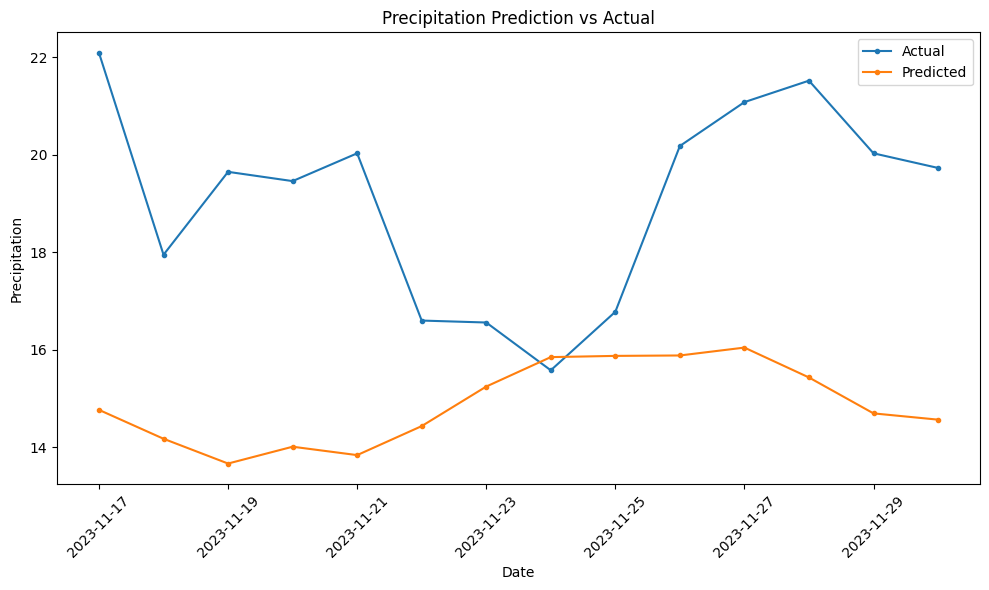

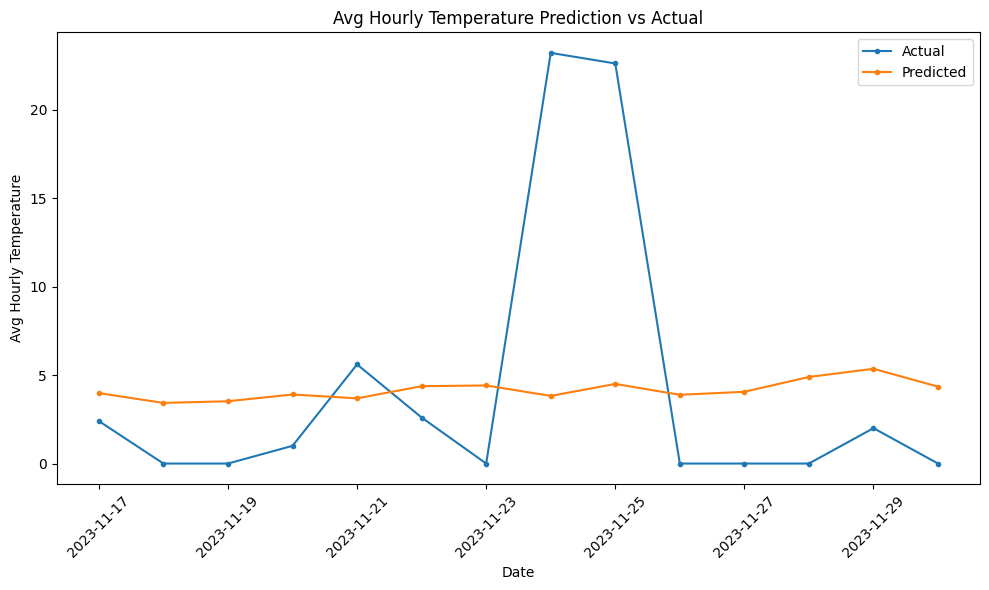

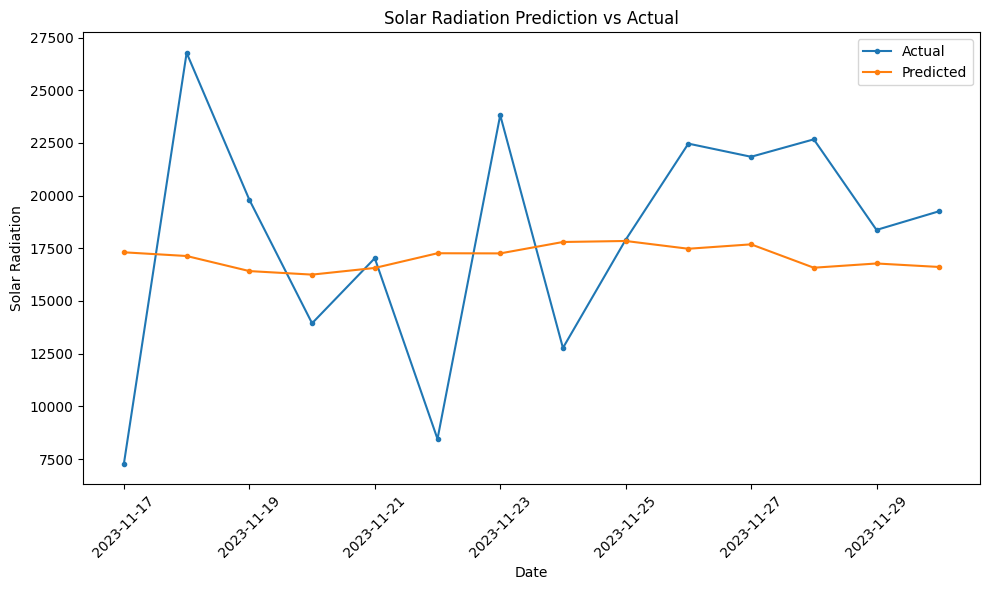

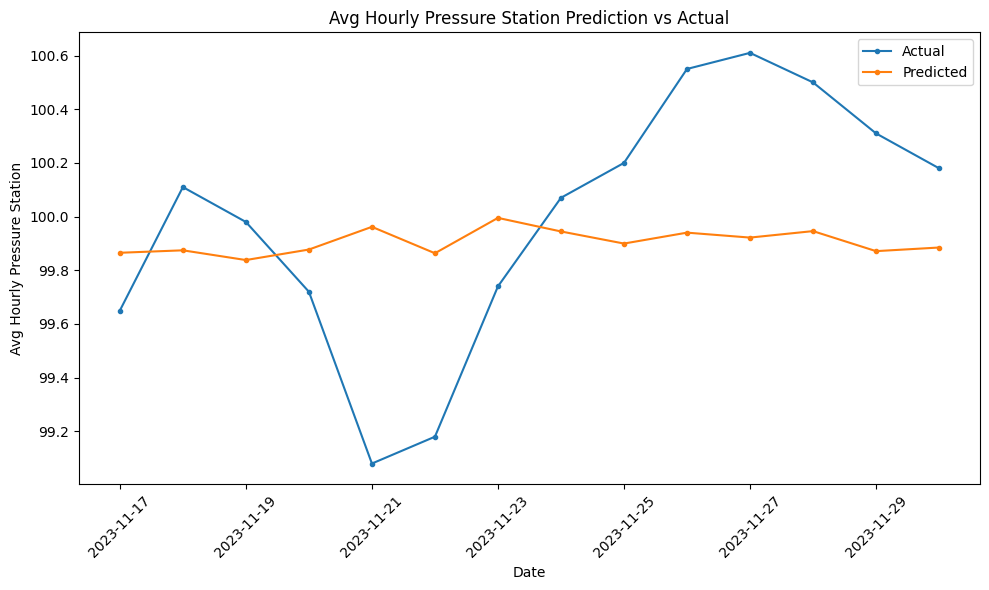

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'predictions' and 'y_test_scaled' are your model's predictions and actual values, respectively, scaled back to their original range

feature_names = ['Precipitation', 'Avg Hourly Temperature', 'Solar Radiation', 'Avg Hourly Pressure Station']
test_dates = test_data['date'].reset_index(drop=True)[:len(predictions)]

for i, feature_name in enumerate(feature_names):
    plt.figure(figsize=(10, 6))
    plt.plot(test_dates, y_test_scaled[:, i], label='Actual', marker='.', zorder=-1)
    plt.plot(test_dates, predictions[:, i], label='Predicted', marker='.', zorder=1)
    plt.title(f'{feature_name} Prediction vs Actual')
    plt.xlabel('Date')
    plt.ylabel(feature_name)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Graph #2

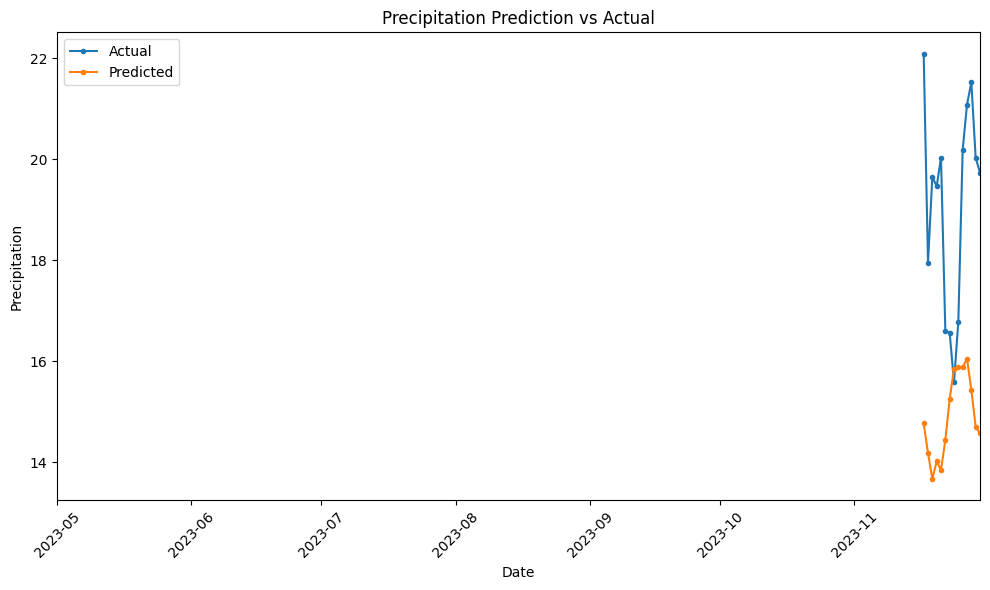

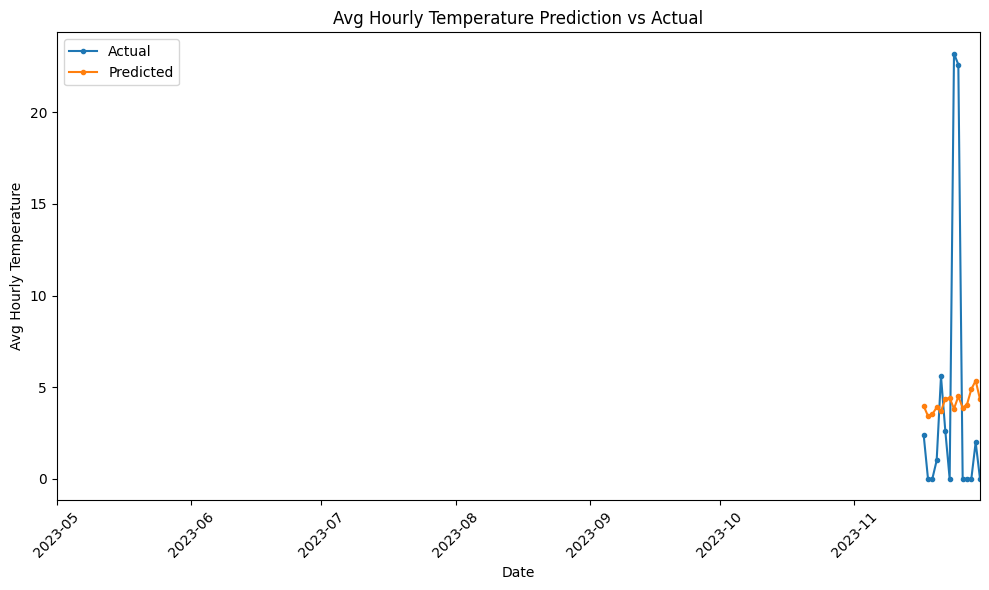

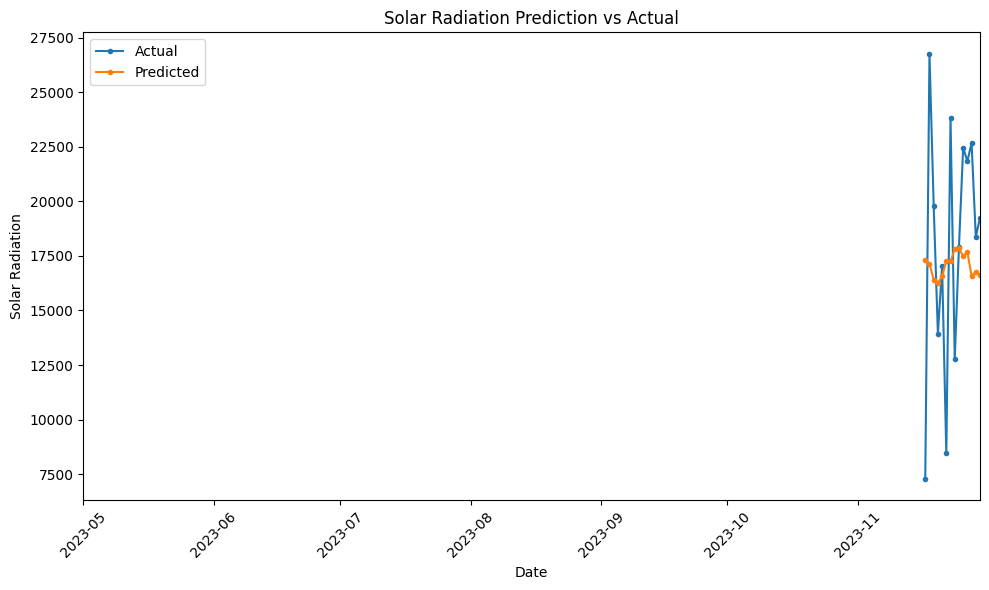

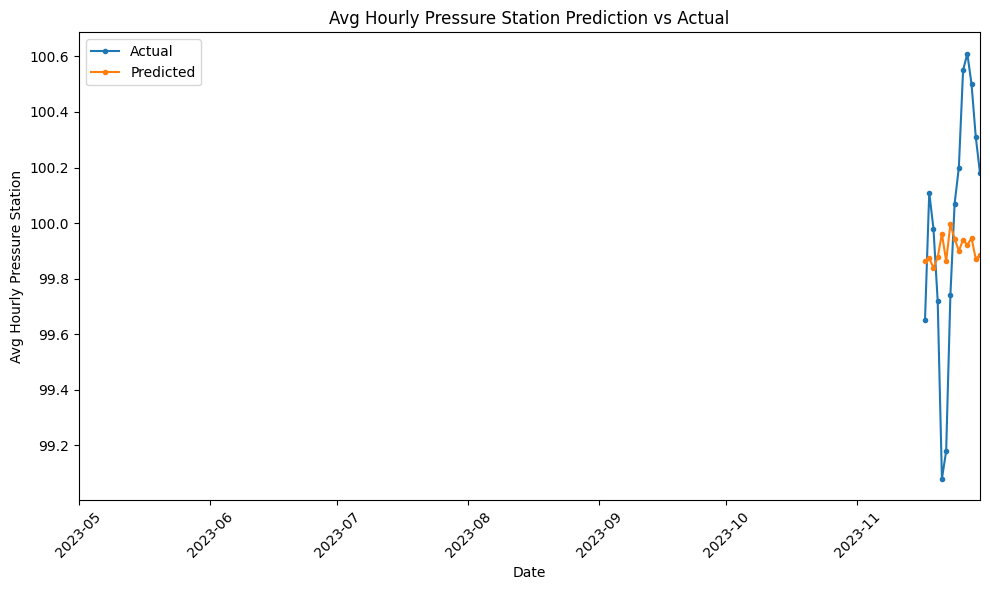

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'predictions' and 'y_test_scaled' are your model's predictions and actual values, respectively, scaled back to their original range
feature_names = ['Precipitation', 'Avg Hourly Temperature', 'Solar Radiation', 'Avg Hourly Pressure Station']
test_dates = test_data['date'].reset_index(drop=True)[:len(predictions)]

# Define start and end dates for the plots
start_date = pd.to_datetime("2023-05-01")  # Adjust the year as necessary
end_date = pd.to_datetime("2023-11-30")  # Adjust the year as necessary

for i, feature_name in enumerate(feature_names):
    plt.figure(figsize=(10, 6))
    plt.plot(test_dates, y_test_scaled[:, i], label='Actual', marker='.', zorder=-1)
    plt.plot(test_dates, predictions[:, i], label='Predicted', marker='.', zorder=1)
    plt.title(f'{feature_name} Prediction vs Actual')
    plt.xlabel('Date')
    plt.ylabel(feature_name)
    plt.legend()
    plt.xticks(rotation=45)

    # Set x-axis to May-November range
    plt.xlim(start_date, end_date)

    plt.tight_layout()
    plt.show()
